In [13]:
%matplotlib inline

import multiprocessing
import distutils.dir_util
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ctypes
import csv
import glob
import os
import sys
import tensorflow as tf
sys.path.append('/nethome/shickson3/CreateNormals/')
from python.calc_normals import NormalCalculation

In [18]:
file_number = 4

image_files = []
depth_files = []
label_files = []
dataset_file = open('/srv/datasets/cityscapes/cityscapes_val.txt','r')
for line in dataset_file:
    fields = line.strip('\n').split(',')
    image_files.append(fields[0])
    depth_files.append(fields[1])
    label_files.append(fields[2])

(1024, 2048, 3)


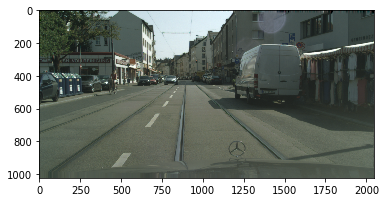

In [19]:
image = cv2.imread(image_files[file_number], cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(image.shape)

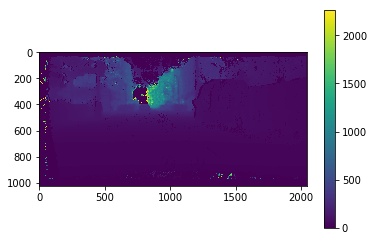

(1024, 2048)
[   0.         17.936508   18.082825 ... 2242.4807   2251.2063
 2260.      ]


In [20]:
depth = (cv2.imread(depth_files[file_number], cv2.IMREAD_ANYDEPTH).astype(np.float32) - 1.0)/ 256
depth[depth <= 0] = -1
depth = 2260 / depth
#depth = 2260 * 0.209313 / depth
#depth[depth == float("inf")] = 0
depth[depth <= 0] = 0
#depth = cv2.imread(depth_files[file_number], cv2.IMREAD_ANYDEPTH)
fig, ax = plt.subplots()
im = plt.imshow(depth)
fig.colorbar(im)
plt.show()
print(depth.shape)
print(np.unique(depth))

[ 1  2  3  4  5  7  8 11 17 19 20 21 23 24 25 26 27 33]
(1024, 2048)
uint8


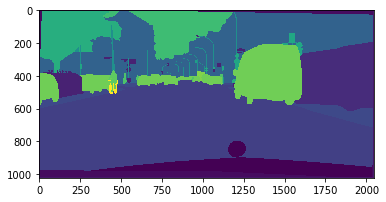

In [21]:
labels = cv2.imread(label_files[file_number], cv2.IMREAD_ANYDEPTH)
plt.imshow(labels)
print(np.unique(labels))
print(labels.shape)
print(labels.dtype)

In [22]:
camera_params = [2262.52,0,1096.98,0,2265.3017905988554,513.137,0,0,1]
normal_params = [15,0.04,50,0.04]
flat_labels = []
norm_calc = NormalCalculation(camera_params, normal_params, flat_labels)
normals = norm_calc.Calculate(depth, labels)

[-1.         -0.99999994 -0.9999999  ...  0.9999999   0.99999994
  1.        ]


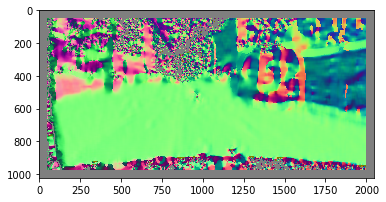

In [23]:
normals_file_name = depth_files[file_number].replace('disparity','normals').replace('.png','.exr')
fields = normals_file_name.split('/')
distutils.dir_util.mkpath('/'.join(fields[:-1]))
cv2.imwrite(normals_file_name, normals)
print np.unique(normals)
plt.imshow((normals + 1) / 2.0)

In [24]:
import multiprocessing
import distutils.dir_util

def process(depth_file, label_file):
    depth = (cv2.imread(depth_file, cv2.IMREAD_ANYDEPTH).astype(np.float32) - 1.0)/ 256
    depth[depth <= 0] = -1
    depth = 2260 / depth
    depth[depth <= 0] = 0
    labels = cv2.imread(label_file, cv2.IMREAD_ANYDEPTH)
    normals = norm_calc.Calculate(depth, labels)
    normals_file_name = depth_file.replace('disparity','normals').replace('.png','.exr')
    fields = normals_file_name.split('/')
    distutils.dir_util.mkpath('/'.join(fields[:-1]))
    cv2.imwrite(normals_file_name, normals)

p = multiprocessing.Pool()
for d,l in zip(depth_files,label_files):
    # launch a process for each file (ish).
    # The result will be approximately one process per CPU core available.
    p.apply_async(process, [d,l]) 

p.close()
p.join()